In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip /content/output.zip

In [6]:
from math import e
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets, transforms
from torchvision.models import resnet34
from sklearn.metrics import f1_score, precision_score, recall_score
from PIL import Image
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import re
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [43]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


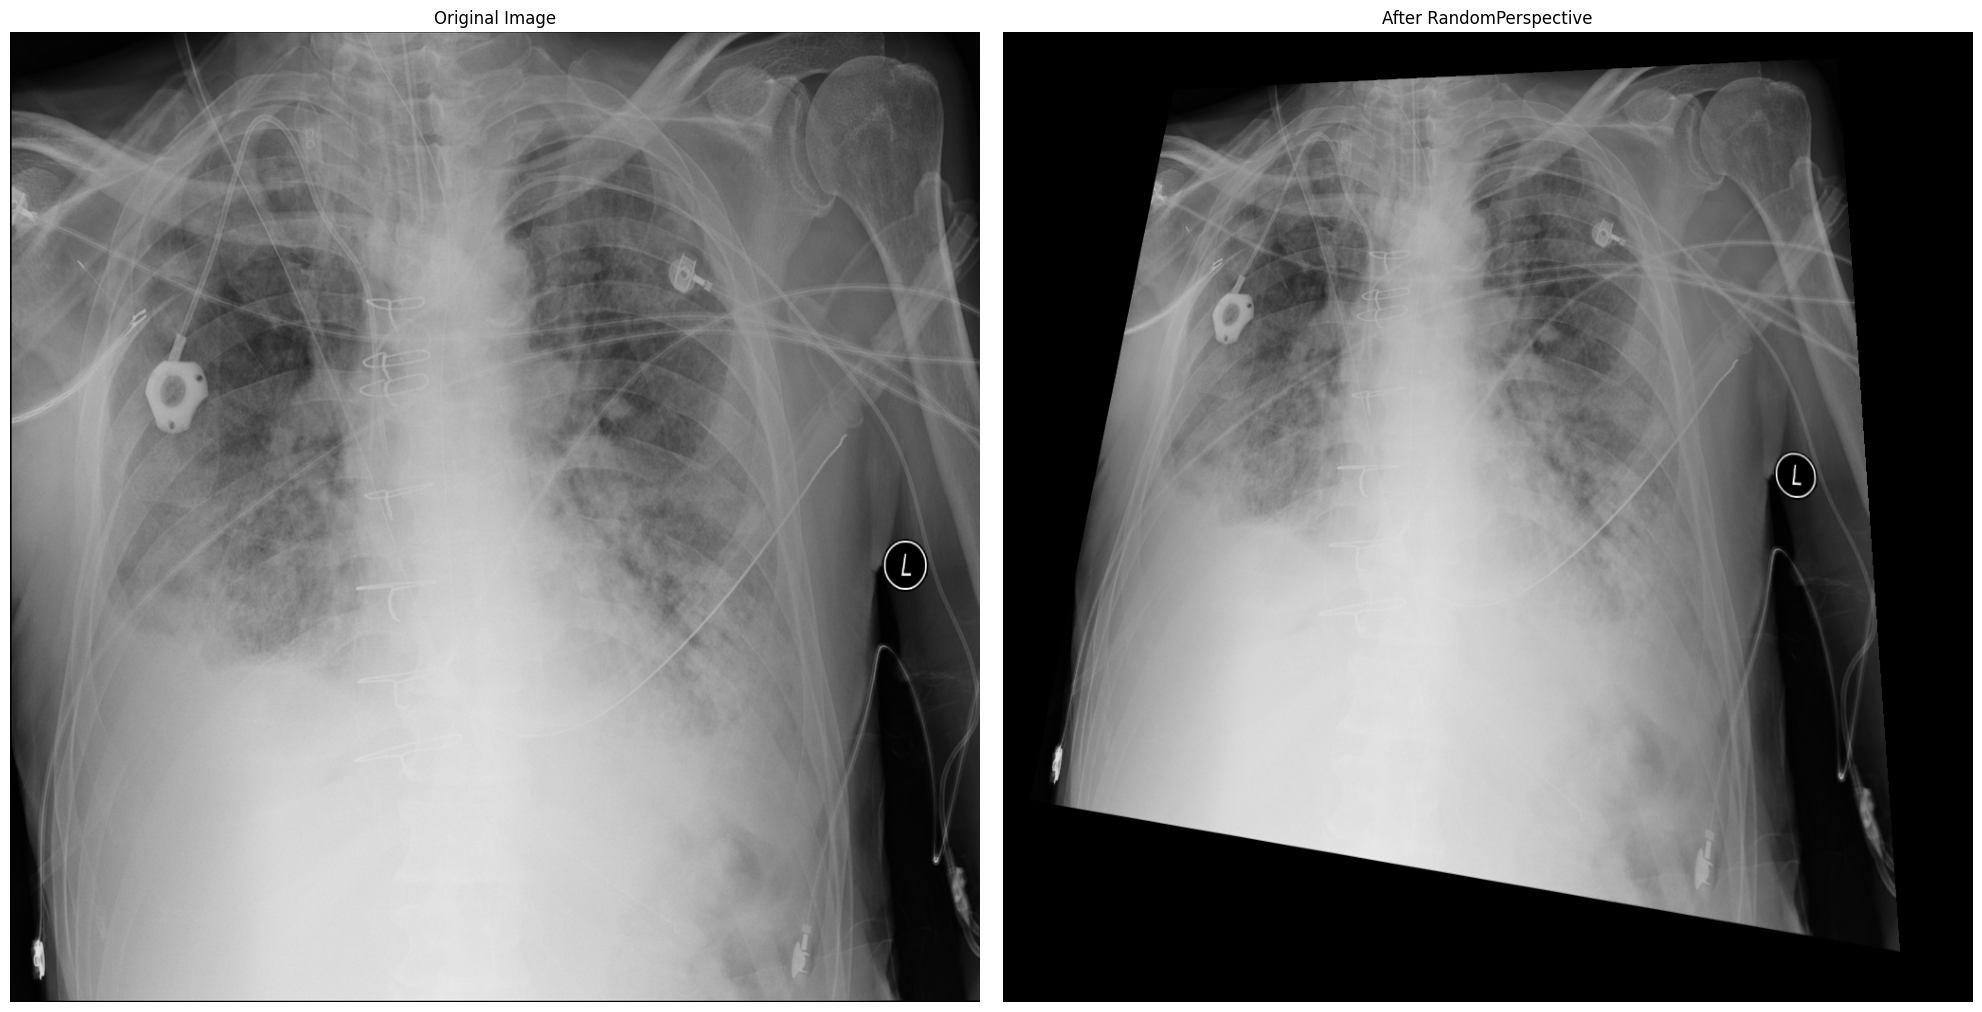

In [43]:
image_path = "/content/train/Infiltration/00000061_024.png"
original_image = Image.open(image_path).convert('RGB')


transform = transforms.RandomPerspective(distortion_scale=0.5, p=1.2)


flipped_image = transform(original_image)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(flipped_image)
plt.title("After RandomPerspective")
plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),               # Slight rotation for variety
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Random cropping
    transforms.RandomHorizontalFlip(p=0.5),              # Horizontal flip
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Color jitter for variability
    transforms.GaussianBlur(3),
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    # Normalization
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                       # Resize to match training input
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    # Normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(r"/content/train", transform=train_transform)

# Calculate class weights from dataset
class_counts = np.bincount([sample[1] for sample in train_dataset.samples])  # Count occurrences of each class
class_weights = 1.0 / class_counts                                           # Inverse class frequency
sample_weights = [class_weights[label] for _, label in train_dataset.samples]  # Assign weights to each sample

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4)

# Validation DataLoader
val_dataset = datasets.ImageFolder(r"/content/val", transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [8]:
class MyResNet(nn.Module):
    def __init__(self, num_classes, dropout_chance=0.5):
        super(MyResNet, self).__init__()
        self.resnet = resnet34(pretrained=True)  # Loading the pre-trained ResNet-34 model
        num_features = self.resnet.fc.in_features  # Getting the number of input features to the last layer
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout_chance),  # Adding a Dropout layer
            nn.Linear(num_features, num_classes)  # Convert the last layer to a linear output layer with num_classes classes
        )

    def forward(self, x):
        return self.resnet(x)

In [9]:
model = MyResNet(num_classes=5, dropout_chance=0.3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s]


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)


In [51]:
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=4, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [44]:
state_dict = torch.load(r"/content/the_best_model3.pt")
model.load_state_dict(state_dict)

<ipython-input-44-eb1f42a262ae>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"/content/the_best_model3.pt")


<All keys matched successfully>

In [52]:
number_of_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Transferring the model to the device

MyResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [53]:
train_precision_history = []
val_precision_history = []
train_recall_history = []
val_recall_history = []
train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []

In [54]:
for epoch in range(number_of_epochs):
    model.train()  # Setting the model to training mode

    running_train_loss = 0.0
    train_labels = []
    train_preds = []

    now = 1
    how_much = str(len(train_loader))

    for images, labels in train_loader:
        print("Epoch: " + str(epoch + 1) + " [" + str(now) + "/" + how_much + "]")
        now += 1

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Transfer images by model
        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backpropagation


        optimizer.step()  # Update weights
        #scheduler.step(val_loss) # disabled

        running_train_loss += loss.item()  # Adding loss
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    # Calculate and save training statistics; loss, precision, recall, f1
    train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
    train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
    train_loss = running_train_loss / len(train_loader)
    train_f1 = f1_score(train_labels, train_preds, average='macro')

    model.eval()
    running_val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Transfer images by model
            loss = criterion(outputs, labels)  # Loss calculation
            running_val_loss += loss.item()  # Adding loss
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    # Calculate and save validation statistics; loss, precision, recall, f1
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=1)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=1)
    val_loss = running_val_loss / len(val_loader)
    val_f1 = f1_score(val_labels, val_preds, average='macro')




    train_precision_history.append(train_precision)
    val_precision_history.append(val_precision)
    train_recall_history.append(train_recall)
    val_recall_history.append(val_recall)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_f1_history.append(train_f1)
    val_f1_history.append(val_f1)

    print(f"Epoch [{epoch + 1}/{number_of_epochs}] Train Loss: {train_loss:.6f} F1: {train_f1:.6f} | Val Loss: {val_loss:.6f} F1: {val_f1:.6f}")

Epoch: 1 [1/86]
Epoch: 1 [2/86]
Epoch: 1 [3/86]
Epoch: 1 [4/86]
Epoch: 1 [5/86]
Epoch: 1 [6/86]
Epoch: 1 [7/86]
Epoch: 1 [8/86]
Epoch: 1 [9/86]
Epoch: 1 [10/86]
Epoch: 1 [11/86]
Epoch: 1 [12/86]
Epoch: 1 [13/86]
Epoch: 1 [14/86]
Epoch: 1 [15/86]
Epoch: 1 [16/86]
Epoch: 1 [17/86]
Epoch: 1 [18/86]
Epoch: 1 [19/86]
Epoch: 1 [20/86]
Epoch: 1 [21/86]
Epoch: 1 [22/86]
Epoch: 1 [23/86]
Epoch: 1 [24/86]
Epoch: 1 [25/86]
Epoch: 1 [26/86]
Epoch: 1 [27/86]
Epoch: 1 [28/86]
Epoch: 1 [29/86]
Epoch: 1 [30/86]
Epoch: 1 [31/86]
Epoch: 1 [32/86]
Epoch: 1 [33/86]
Epoch: 1 [34/86]
Epoch: 1 [35/86]
Epoch: 1 [36/86]
Epoch: 1 [37/86]
Epoch: 1 [38/86]
Epoch: 1 [39/86]
Epoch: 1 [40/86]
Epoch: 1 [41/86]
Epoch: 1 [42/86]
Epoch: 1 [43/86]
Epoch: 1 [44/86]
Epoch: 1 [45/86]
Epoch: 1 [46/86]
Epoch: 1 [47/86]
Epoch: 1 [48/86]
Epoch: 1 [49/86]
Epoch: 1 [50/86]
Epoch: 1 [51/86]
Epoch: 1 [52/86]
Epoch: 1 [53/86]
Epoch: 1 [54/86]
Epoch: 1 [55/86]
Epoch: 1 [56/86]
Epoch: 1 [57/86]
Epoch: 1 [58/86]
Epoch: 1 [59/86]
Epoch:

In [15]:
torch.save(model.state_dict(), 'the_best_model3.pt');

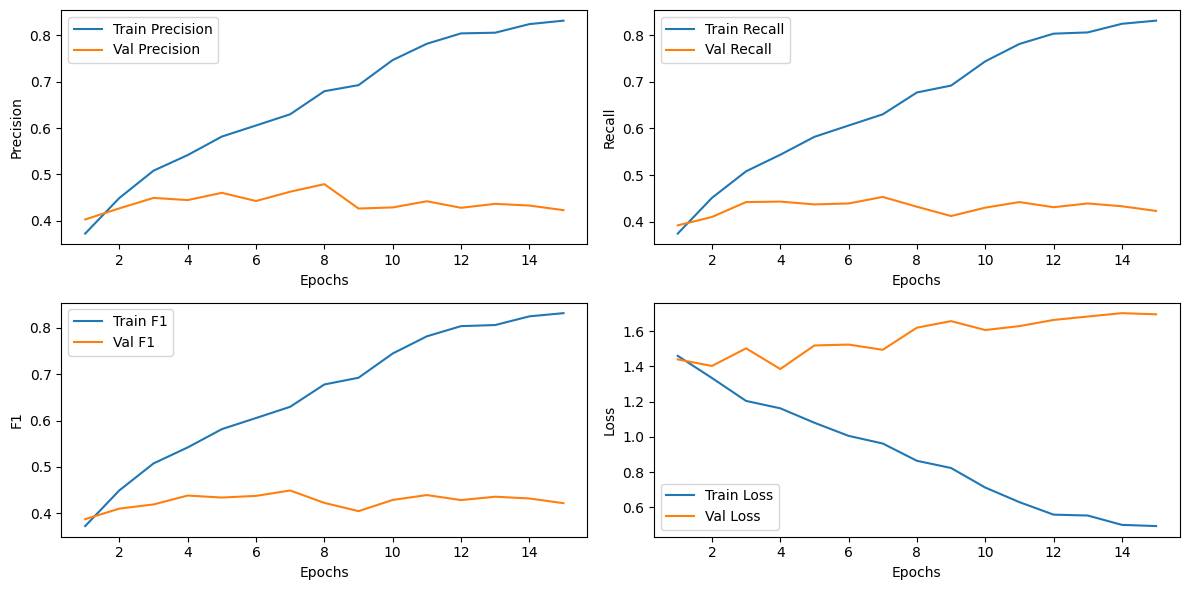

In [16]:
plt.figure(figsize=(12, 6))

plot_range = []

for i in range(number_of_epochs):
    plot_range.append(i + 1)

# Loss
plt.subplot(2, 2, 4)
plt.plot(plot_range, train_loss_history, label='Train Loss')
plt.plot(plot_range, val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 1)
plt.plot(plot_range, train_precision_history, label='Train Precision')
plt.plot(plot_range, val_precision_history, label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 2)
plt.plot(plot_range, train_recall_history, label='Train Recall')
plt.plot(plot_range, val_recall_history, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# f1
plt.subplot(2, 2, 3)
plt.plot(plot_range, train_f1_history, label='Train F1')
plt.plot(plot_range, val_f1_history, label='Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.tight_layout()

# Display graphs showing training results
plt.show()

In [55]:
def predict_class(model_to_prediction, image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model_to_prediction.eval()
    with torch.no_grad():
        outputs_to_prediction = model_to_prediction(image)
        predicted_class = torch.argmax(outputs_to_prediction, dim=1).item()

        # Display probabilities for all class indices
        print("===========================================================================\n")

        probabilities = F.softmax(outputs_to_prediction, dim=1)
        for i in range(10):
            class_probability = probabilities[0, i].item()
            print("Probability for class index ", i, " : ", class_probability)

        print("\n===========================================================================\n")

    return predicted_class

In [56]:
def view_prediction(list_of_paths):
    class_map = {
        0: 'Atelectasis',
        1: 'Effusion',
        2: 'Infiltration',
        3: 'Mass',
        4: 'Nodule',
    }

    for path in list_of_paths:
        predicted_class_index = predict_class(model, path)

        match = re.search(r'test_(\w+)', path)

        if match:
            true_class_index = match.group(1)
            print(f'True class: {class_map[int(true_class_index)]}, True class index: {true_class_index}')
            print(f'Predicted class: {class_map[predicted_class_index]}, Predicted class index: {predicted_class_index}\n')

In [73]:
def predict_class(model_to_prediction, image_path):
    class_map = {
        0: 'Atelectasis',
        1: 'Effusion',
        2: 'Infiltration',
        3: 'Mass',
        4: 'Nodule',
    }

    image = Image.open(image_path).convert('RGB')
    image = transforms.ToTensor()(image)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model_to_prediction.eval()
    with torch.no_grad():
        outputs_to_prediction = model_to_prediction(image)
        predicted_class = torch.argmax(outputs_to_prediction, dim=1).item()

        print("===========================================================================\n")

        probabilities = F.softmax(outputs_to_prediction, dim=1)
        num_classes = probabilities.shape[1]
        for i in range(num_classes):
            class_probability = probabilities[0, i].item()
            class_name = class_map.get(i, f'Unknown Class {i}')
            print(f"Probability for class {class_name} (index {i}): {class_probability}")

        print("\n===========================================================================\n")

    return predicted_class

In [72]:
predict_class(model, "/content/val/Nodule/00002288_012.png")


Probability for class Atelectasis (index 0): 0.09614711999893188
Probability for class Effusion (index 1): 0.09811816364526749
Probability for class Infiltration (index 2): 0.25761905312538147
Probability for class Mass (index 3): 0.13273519277572632
Probability for class Nodule (index 4): 0.41538047790527344




4